<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/RCNN_objectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting  object detection

In [ ]:
!pip install torch_snippets
!pip install  selectivesearch
from  torch_snippets  import *
from  skimage.segmentation import felzenszwalb


In [ ]:
img =  read('/content/01ba35d1c832411398328243b30812bc71667b14-1440x810-2.jpg',1)

In [ ]:
img

array([[[175, 134, 104],
        [174, 133, 103],
        [174, 133, 103],
        ...,
        [ 92,  91,  97],
        [ 69,  68,  74],
        [ 55,  54,  60]],

       [[176, 135, 105],
        [174, 133, 103],
        [174, 133, 103],
        ...,
        [ 99,  98, 104],
        [ 65,  64,  70],
        [ 87,  86,  92]],

       [[176, 135, 105],
        [175, 134, 104],
        [177, 133, 104],
        ...,
        [ 77,  76,  82],
        [ 76,  75,  81],
        [105, 104, 110]],

       ...,

       [[181, 141, 106],
        [180, 140, 105],
        [180, 139, 107],
        ...,
        [186, 145, 115],
        [186, 145, 115],
        [185, 144, 114]],

       [[184, 144, 109],
        [184, 144, 109],
        [183, 142, 110],
        ...,
        [188, 147, 115],
        [187, 146, 116],
        [188, 147, 117]],

       [[186, 146, 111],
        [186, 146, 111],
        [185, 144, 112],
        ...,
        [190, 149, 117],
        [189, 148, 118],
        [189, 148, 118]]

In [ ]:
segment_fz = felzenszwalb(img,scale=200)

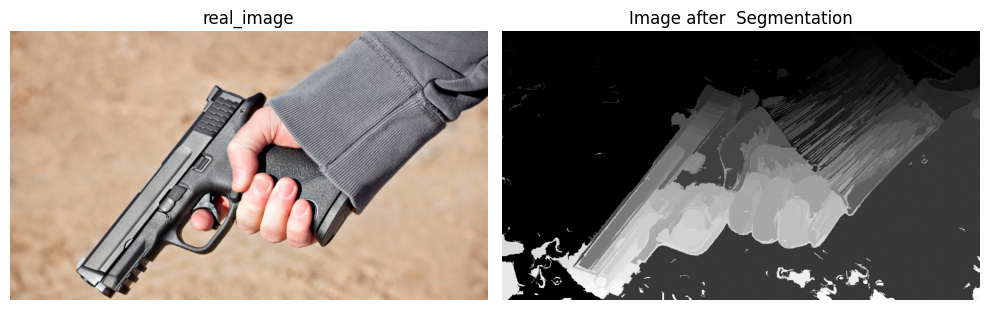

In [ ]:
subplots([img,segment_fz],titles =  ['real_image','Image after  Segmentation'],sz=10,nc=2)

In [ ]:
img.shape

(810, 1440, 3)

In [ ]:
import selectivesearch
def extract_features(img):
  img_lbl,regions = selectivesearch.selective_search(img,scale=200,min_size=100)
  candidates=  []
  img_area =  np.prod(img.shape[:2])
  for r in  regions:
    if r['rect'] in candidates:continue
    if r['size'] < (0.05*img_area):continue
    if r['size'] > (1*img_area):continue
    x,y,w,h = r['rect']
    candidates.append(list(r['rect']))
  return candidates

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


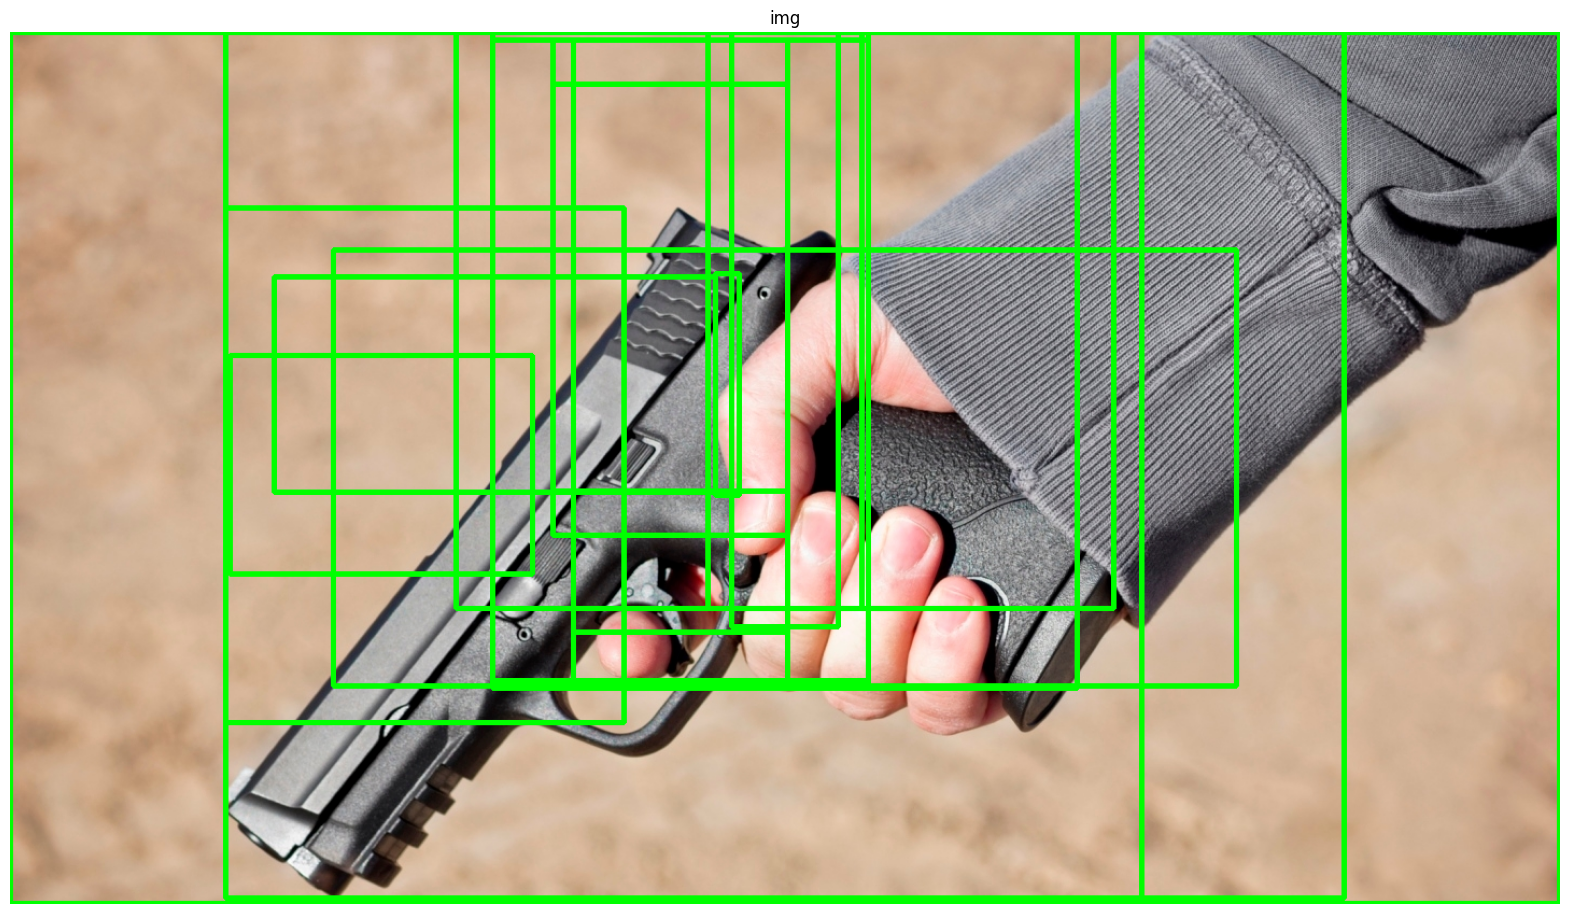

In [ ]:
candidates = extract_features(img)
show(img,bbs=candidates)

In [ ]:
def  get_iou(boxA,boxB,ep=1e-5):
  x1 = max(boxA[0],boxB[0])
  y1 = max(boxA[1],boxB[1])
  x2 = min(boxA[2],boxB[2])
  y2 = min(boxA[3],boxB[3])

  width = (x2-x1)
  height = (y2-y1)

  if (width<0) or (height<0):
    return 0.0
  area_overlap  = width *  height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap
  iou =  area_overlap/(area_combined + ep)
  return iou

# RCNN

In [ ]:
!pip  install  opendatasets
import torch
import cv2
import torch.nn as  nn
import  selectivesearch
from torch_snippets import *
from torch_snippets.torch_loader import Report
from  torchvision import transforms,models,datasets
from torch.utils.data import  DataLoader,Dataset
from torchvision.ops import nms
device =  'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: korlilarryaddo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks


100%|██████████| 367M/367M [00:00<00:00, 616MB/s]


In [ ]:
IMAGE_ROOT = '/content/open-images-bus-trucks/images/images'
df_raw = pd.read_csv('/content/open-images-bus-trucks/df.csv')
df_raw.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [ ]:
class openImages(Dataset):
  def __init__(self,df,image_folder=IMAGE_ROOT):
    self.root = image_folder
    self.df =  df
    self.unique_images = df['ImageID'].unique()

  def __len__(self):
    return  len(self.unique_images)

  def __getitem__(self,ix):
    image_id = self.unique_images[ix]
    image_path = f'{self.root}/{image_id}.jpg'

    image =  cv2.imread(image_path,1)[...,::-1]#BGR ->  RGB
    h,w,_ = image.shape
    df = self.df.copy()
    df = df[df['ImageID']==image_id]
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16).tolist()
    classes =  df['LabelName'].values.tolist()
    return image,boxes,classes,image_path



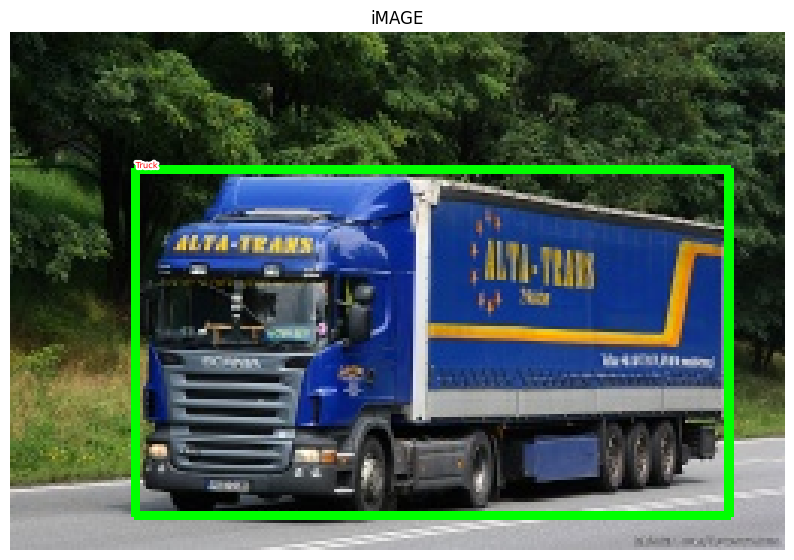

In [ ]:
ds = openImages(df=df_raw)
im,bbs,clss,_  = ds[9]
show(im,bbs=bbs,texts=clss,sz=10,title='iMAGE')

In [ ]:
def extract_features(img):
  img_lbl,regions = selectivesearch.selective_search(img,scale=200,min_size=100)
  candidates=  []
  img_area =  np.prod(img.shape[:2])
  for r in  regions:
    if r['rect'] in candidates:continue
    if r['size'] < (0.05*img_area):continue
    if r['size'] > (1*img_area):continue
    x,y,w,h = r['rect']
    candidates.append(list(r['rect']))
  return candidates

In [ ]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]
N= 500
for ix,(im,bbs,labels,fpaths) in enumerate(ds):
  if  (ix==N):
    break
  H,W,_ = im.shape
  candidates =  extract_features(im)
  candidates = np.array([(x,y,x+w,y+h)  for  x,y,w,h in candidates])
  ious,rois,clss,deltas = [],[],[],[]
  ious = np.array([[extract_iou(candidate,_bb_)
                  for  candidate in  candidates] for  _bb_ in  bbs]).T
  for jx,candidate in enumerate(candidates):
    cx,cy,cX,cY = candidate
    candidate_ious = ious[jx]
    best_iou_at =  np.argmax(candidate_ious)
    best_iou =  candidate_ious[best_iou_at]
    best_bb = x_,y_,X_,Y_ = bbs[best_iou_at]
    if best_iou>0.3:
      clss.append(labels[best_iou_at])
    else:
      clss.append('background')
    delta = np.array([x_-cx,y_-cy,X_-cX,Y_-cY]/np.array([W,H,W,H]))
    deltas.append(delta)
    rois.append(candidate/np.array([W,H,W,H]))
  FPATHS.append(fpaths)
  IOUS.append(ious)
  ROIS.append(rois)
  CLSS.append(clss)
  DELTAS.append(deltas)
  GTBBS.append(bbs)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [ ]:
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [ ]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [ ]:
background_class

1

In [ ]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])

def preprocess_image(img):
  img =  torch.tensor(img).permute(2,0,1)
  img = normalize(img)
  return img.to(device).float()
def  decode(y):
  pred = torch.argmax(y,dim=1)
  return pred

class  RCNNDataset(Dataset):
  def __init__(self,fpaths,rois,labels,deltas,gtbbs):
    self.fpaths = fpaths
    self.gtbbs = gtbbs
    self.rois = rois
    self.labels  = labels
    self.deltas = deltas

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self,ix):
    fpath =  str(self.fpaths[ix])
    #image = cv2.imread(fpath,1)[...,::-1]
    image = cv2.cvtColor(cv2.imread(fpath),cv2.COLOR_BGR2RGB)
    H,W,_ = image.shape
    sh = np.array([W,H,W,H])
    gtbbs =  self.gtbbs[ix]
    rois = self.rois[ix]
    bbs = (np.array(rois)*sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    crops =  [image[y:Y,x:X]  for (x,y,X,Y)  in  bbs]
    return image,crops,bbs,labels,deltas,gtbbs,fpaths
  def  collate_fn(self,batch):
    input, rois, rixs, labels, deltas =[],[],[],[],[]
    for ix  in  range(len(batch)):
      image,crops,image_bbs,image_labels,image_deltas,image_gt_bbs,image_fpath = batch[ix]
      crops = [cv2.resize(crop,(224,224)) for  crop  in  crops]
      crops = [preprocess_image(crop/255) for crop  in  crops]
      input.extend(crops)
      labels.extend([label2target[c]  for c in image_labels])
      deltas.extend(image_deltas)
    input  = torch.stack(input).to(device)
    labels  = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input,labels,deltas


In [ ]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train],ROIS[:n_train],
                       CLSS[:n_train], DELTAS[:n_train],
                       GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:],
                      CLSS[n_train:], DELTAS[n_train:],
                      GTBBS[n_train:])

train_loader = DataLoader(train_ds, batch_size=2,
                          collate_fn=train_ds.collate_fn,
                          drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2,
                         collate_fn=test_ds.collate_fn,
                         drop_last=True)

In [ ]:
w =  models.VGG16_Weights.IMAGENET1K_V1
vgg_backbone = models.vgg16(weights=w)
vgg_backbone.classifier  =  nn.Sequential()
for p  in vgg_backbone.parameters():
  p.requires_grad = False
vgg_backbone.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(vgg_backbone,(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 25088]                --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [ ]:
class RCNN(nn.Module):
  def __init__(self):
    super().__init__()
    feature_dim  = 25088
    self.backbone = vgg_backbone
    self.clc_score = nn.Linear(feature_dim,len(label2target))
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim,512),
        nn.ReLU(),
        nn.Linear(512,4),
        nn.Tanh(),
    )
    self.cel = nn.CrossEntropyLoss()
    self.sli =  nn.L1Loss()
  def forward(self,input):
    feat = self.backbone(input)
    clc_score =  self.clc_score(feat)
    bbox = self.bbox(feat)
    return  clc_score,bbox

  def calc_loss(self,probs,_deltas,labels,deltas):
    detection_loss =  self.cel(probs,labels)
    ixs = torch.where(labels!=0)
    _deltas = _deltas[ixs]
    deltas = deltas[ixs]
    self.lmb =  10.0
    if (labels!=0).any()>0:
      regression_loss = self.sli(_deltas,deltas)
      return detection_loss + self.lmb *  regression_loss,detection_loss.detach(),regression_loss.detach()
    else:
      regression_loss = 0
      return detection_loss+self.lmb *  regression_loss,detection_loss.detach(),regression_loss

In [ ]:
from sklearn.metrics  import  accuracy_score
def train_batch(inputs,model,optimizer,criterion):
  input,clss,deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clss,_deltas =  model(input)
  loss,loc_loss,regr_loss = criterion(_clss,_deltas,clss,deltas)
  acc = (decode(_clss)== clss).float().mean().item()
  loss.backward()
  optimizer.step()
  return  loss.detach(),loc_loss,regr_loss,acc


@torch.no_grad()
def val_batch(inputs,model,criterion):
  input,clss,deltas =  inputs
  model.eval()
  _clss,_deltas  =  model(input)
  loss,loc_loss,regr_loss = criterion(_clss,_deltas,clss,deltas)
  preds = decode(_clss)
  acc =  (preds ==clss).float().mean().item()
  return preds,_deltas,loss.detach(),loc_loss,regr_loss,acc

In [ ]:
from torch.optim  import SGD
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [ ]:
torch.manual_seed(42)

In [ ]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix,inputs in enumerate(train_loader):
    loss,loc_loss,regr_loss,acc =  train_batch(inputs,rcnn,optimizer,criterion)
    pos  =  (epoch+(ix+1)/_n)
    log.record(pos,
               trn_loss=loss.item(),
               trn_loc_loss  =  loc_loss,
               trn_regr_loss = regr_loss,
               trn_acc=acc,end='\r')
  _n = len(test_loader)
  for ix,inputs in enumerate(test_loader):
    preds,_deltas,loss,loc_loss,regr_loss,acc =  val_batch(inputs,rcnn,criterion)
    pos  =  (epoch+(ix+1)/_n)
    log.record(pos,
               val_loss=loss.item(),
               val_loc_loss  =  loc_loss,
               val_regr_loss = regr_loss,
               val_acc=acc,end='\r')


100%|██████████| 106/106 [00:00<00:00, 3872.49it/s]


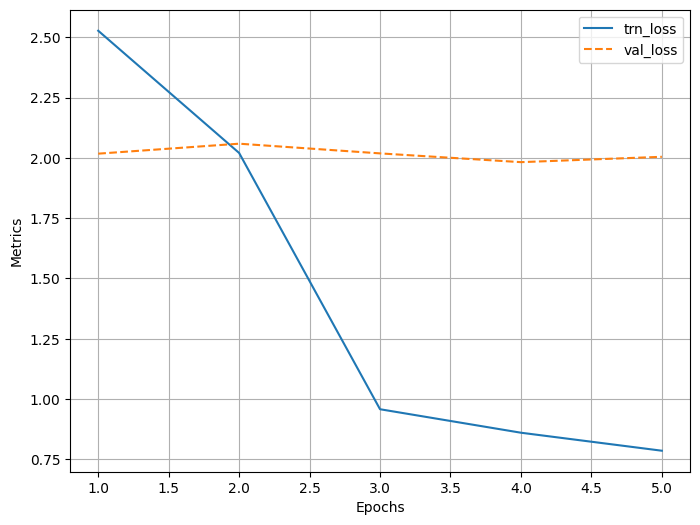

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
import matplotlib.pyplot as plt

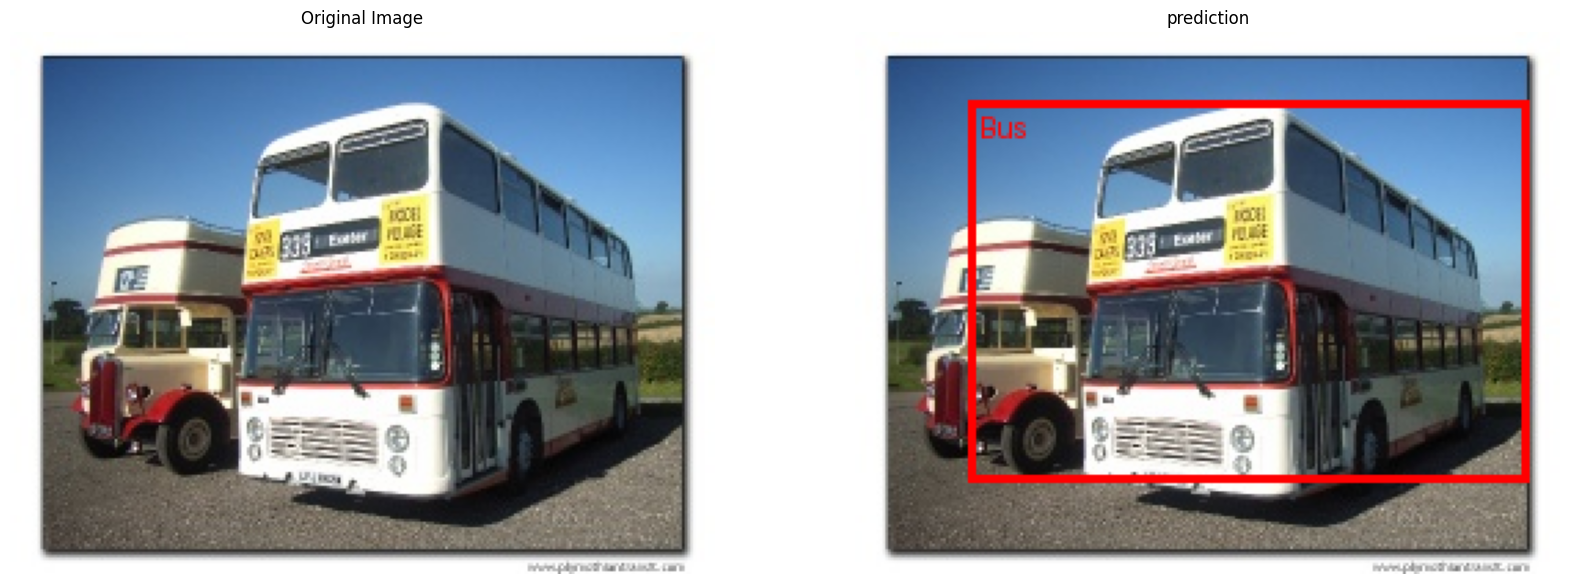

((np.uint16(41), np.uint16(25), np.uint16(244), np.uint16(163)),
 'Bus',
 np.float32(0.99998426))

In [ ]:
def  test_predictions(filename,show_output=True):
  img = np.array(cv2.imread(filename,1)[...,::-1])
  candidates = extract_features(img)
  candidates  = [(x,y,x+w,y+h)  for x,y,w,h in candidates]
  input = []
  for candidate in candidates:
    x,y,X,Y = candidate
    crop = cv2.resize(img[y:Y,x:X],(224,224))
    input.append(preprocess_image(crop/255.))
  input  = torch.stack(input).to(device)

  with torch.no_grad():
    rcnn.eval()
    probs,deltas  = rcnn(input)
    probs  =  torch.nn.functional.softmax(probs,-1)
    confs,clss = torch.max(probs,-1)
  candidates  = np.array(candidates)
  confs,clss,probs,deltas = [tensor.detach().cpu().numpy()  for tensor in [confs,clss,probs,deltas]]
  ixs  = clss!=background_class
  confs,clss,probs,deltas,candidates = [tensor[ixs] for tensor in [confs,clss,probs,deltas,candidates]]
  bbs =  (candidates+deltas).astype(np.uint16)
  ixs =  nms(torch.tensor(bbs.astype(np.float32)),
             torch.tensor(confs),0.05)
  confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
  if  len(ixs)==1:
    confs,clss,probs,deltas,candidates,bbs =  [tensor[None] for tensor  in  [confs,clss,probs,deltas,candidates,bbs]]
  if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
  if  len(confs)>0:
    best_pred  = np.argmax(confs)
    best_conf = np.max(confs)
    best_bb = bbs[best_pred]
    x,y,X,Y = best_bb
  _,ax = plt.subplots(1,2,figsize=(20,10))
  show(img,ax=ax[0])
  ax[0].grid(False)
  ax[0].set_title('Original Image')
  if  len(confs)==0:
    ax[1].imshow(img)
    ax[1].set_title('No Objects')
    plt.show()
    return
  ax[1].set_title(target2label[clss[best_pred]])
  #show(img,bbs=bbs.tolist(),texts=[target2label[c]  for  c in  clss.tolist()],ax=ax[1],title='prediction')
  from torchvision.utils import draw_bounding_boxes
  import torchvision.transforms.functional as F

  # Convert image to tensor
  img_tensor = torch.from_numpy(img).permute(2, 0, 1).to(torch.uint8)  # C×H×W

  # Create boxes tensor
  boxes_tensor = torch.tensor(bbs, dtype=torch.int)

  # Draw boxes and labels
  annotated = draw_bounding_boxes(
      img_tensor,
      boxes_tensor,
      labels=[target2label[c] for c in clss.tolist()],
      colors="red",
      width=3,
      font_size=16,
      fill=False
  )

  # Convert to PIL / numpy and display
  annotated_np = F.to_pil_image(annotated).convert("RGB")
  ax[1].imshow(annotated_np)
  ax[1].axis('off')
  ax[1].set_title('prediction')




  plt.show()
  return (x,y,X,Y),target2label[clss[best_pred]],best_conf
image,crops,bbs,labels,deltas,gtbbs,fpath =  test_ds[19]
test_predictions(fpath)